

# Bayesian Estimation of Differential Equations

Most of the scientific community deals with the basic problem of trying to mathematically model the reality around them and this often involves dynamical systems. The general trend to model these complex dynamical systems is through the use of differential equations. Differential equation models often have non-measurable parameters. The popular “forward-problem” of simulation consists of solving the differential equations for a given set of parameters, the “inverse problem” to simulation, known as parameter estimation, is the process of utilizing data to determine these model parameters. Bayesian inference provides a robust approach to parameter estimation with quantified uncertainty.

In [1]:
using Turing, Distributions, DataFrames, DifferentialEquations, DiffEqSensitivity

# Import MCMCChain, Plots, and StatsPlots for visualizations and diagnostics.
using MCMCChains, Plots, StatsPlots

# Set a seed for reproducibility.
using Random
Random.seed!(12);

┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1260


## The Lotka-Volterra Model

The Lotka–Volterra equations, also known as the predator–prey equations, are a pair of first-order nonlinear differential equations, frequently used to describe the dynamics of biological systems in which two species interact, one as a predator and the other as prey. The populations change through time according to the pair of equations:

$\frac{dx}{dt} = (\alpha - \beta y)x$
 
$\frac{dy}{dt} = (\delta x - \gamma)y$


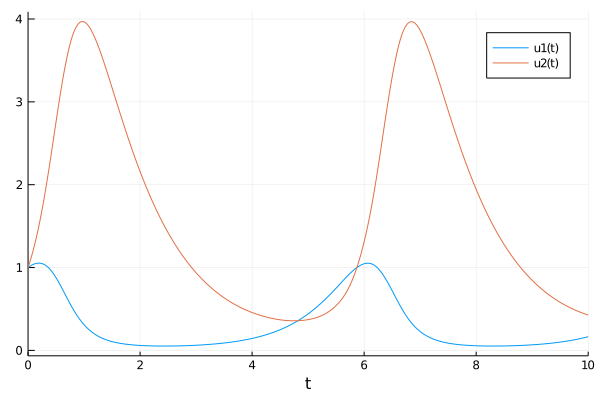

In [2]:
function lotka_volterra(du,u,p,t)
  x, y = u
  α, β, δ, γ = p
  du[1] = dx = (α - β*y)x
  du[2] = dy = (δ*x - γ)y
end
p = [1.5, 1.0, 3.0, 1.0]
u0 = [1.0,1.0]
prob = ODEProblem(lotka_volterra,u0,(0.0,10.0),p)
sol = solve(prob,Tsit5())
plot(sol)

We'll generate the data to use for the parameter estimation from simulation. 
With the `saveat` [argument](https://docs.sciml.ai/latest/basics/common_solver_opts/) we specify that the solution is stored only at `0.1` time units. 

In [3]:
odedata = Array(solve(prob,Tsit5(),saveat=0.1))

2×101 Array{Float64,2}:
 1.0  1.03981  1.05332  1.03247  0.972908  …  0.133965  0.148601  0.165247
 1.0  1.22939  1.52387  1.88714  2.30908      0.476902  0.450153  0.426924

## Fitting Lotka-Volterra with DiffEqBayes

[DiffEqBayes.jl](https://github.com/SciML/DiffEqBayes.jl) is a high level package that set of extension functionality for estimating the parameters of differential equations using Bayesian methods. It allows the choice of using CmdStan.jl, Turing.jl, DynamicHMC.jl and ApproxBayes.jl to perform a Bayesian estimation of a differential equation problem specified via the DifferentialEquations.jl interface. You can read the [docs](https://docs.sciml.ai/latest/analysis/parameter_estimation/#Bayesian-Methods-1) for an understanding of the available functionality.

In [4]:
using DiffEqBayes
t = 0:0.1:10.0
priors = [truncated(Normal(1.5,0.5),0.5,2.5),truncated(Normal(1.2,0.5),0,2),truncated(Normal(3.0,0.5),1,4),truncated(Normal(1.0,0.5),0,2)]
Random.seed!(123)
bayesian_result_turing = turing_inference(prob,Tsit5(),t,odedata,priors,num_samples=10_000)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/vaibhav/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629


Object of type Chains, with data of type 9000×17×1 Array{Float64,3}

Iterations        = 1:9000
Thinning interval = 1
Chains            = 1
Samples per chain = 9000
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = theta[1], theta[2], theta[3], theta[4], σ[1]

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se    mcse        ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ─────────  ──────
    theta[1]  1.5000  0.0060    0.0001  0.0001  2367.0859  0.9999
    theta[2]  1.0000  0.0038    0.0000  0.0001  2459.0814  0.9999
    theta[3]  3.0000  0.0046    0.0000  0.0001  4144.1017  0.9999
    theta[4]  1.0000  0.0033    0.0000  0.0001  2336.2093  0.9999
        σ[1]  0.0151  0.0010    0.0000  0.0000  4108.5346  0.9999

Quantiles
  parameters    2.5%   25.0%   50.0%  

The estimated parameters are clearly very close to the desired parameter values. We can also check that the chains have converged in the plot.

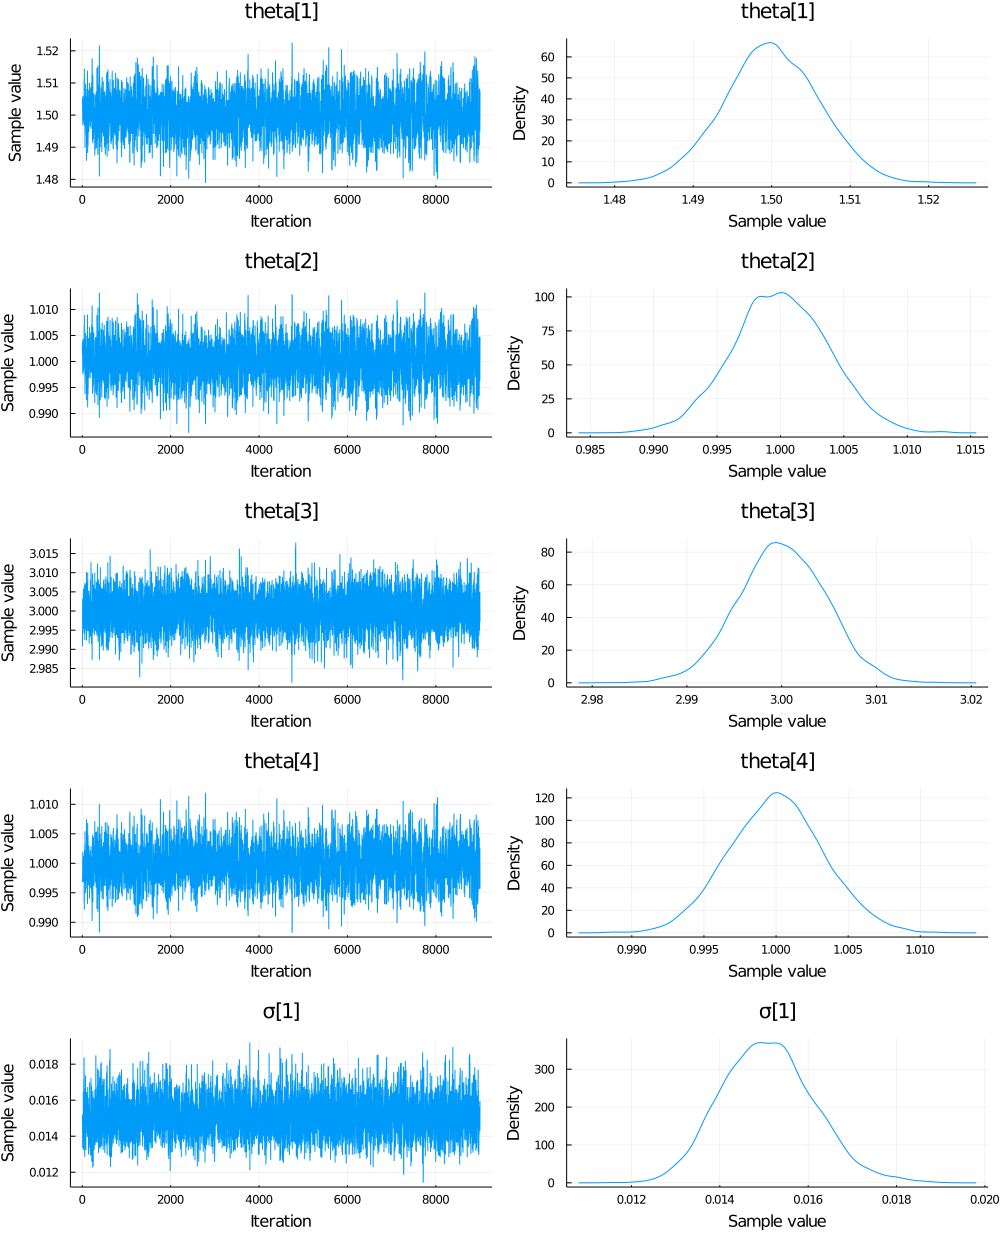

In [5]:
plot(bayesian_result_turing)

## Direct Handling of Bayesian Estimation with Turing

You could want to do some sort of reduction with the differential equation's solution or use it in some other way as well. In those cases DiffEqBayes might not be useful. Turing and DifferentialEquations are completely composable and you can write of the differential equation inside a Turing `@model` and it will just work.

We can rewrite the Lotka Volterra parameter estimation problem with a Turing `@model` interface as below

In [8]:
Turing.setadbackend(:forwarddiff)

@model function fitlv(data)
    σ ~ InverseGamma(2, 3)
    α ~ truncated(Normal(1.5,0.5),0.5,2.5)
    β ~ truncated(Normal(1.2,0.5),0,2)
    γ ~ truncated(Normal(3.0,0.5),1,4)
    δ ~ truncated(Normal(1.0,0.5),0,2)

    p = [α,β,γ,δ]
    prob = ODEProblem(lotka_volterra,u0,(0.0,10.0),p)
    predicted = solve(prob,Tsit5(),saveat=0.1)

    for i = 1:length(predicted)
        data[:,i] ~ MvNormal(predicted[i], σ)
    end
end

model = fitlv(odedata)
chain = sample(model, NUTS(.65),10000)

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/vaibhav/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:06:07


Object of type Chains, with data of type 9000×17×1 Array{Float64,3}

Iterations        = 1:9000
Thinning interval = 1
Chains            = 1
Samples per chain = 9000
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = α, β, γ, δ, σ

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se    mcse        ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ─────────  ──────
           α  2.2000  0.0061    0.0001  0.0001  2405.1847  1.0023
           β  1.0000  0.0025    0.0000  0.0000  2546.6835  1.0020
           γ  2.0000  0.0028    0.0000  0.0000  4274.9217  1.0008
           δ  0.4000  0.0007    0.0000  0.0000  2345.1657  1.0023
           σ  0.0151  0.0011    0.0000  0.0000  4558.6907  1.0003

Quantiles
  parameters    2.5%   25.0%   50.0%   75.0%   97.5%
  ──────────  ──

## Scaling to Large Models: Adjoint Sensitivities

DifferentialEquations.jl's efficiency for large stiff models has been shown in multiple [benchmarks](https://github.com/SciML/DiffEqBenchmarks.jl). To learn more about how to optimize solving performance for stiff problems you can take a look at the [docs](https://docs.sciml.ai/latest/tutorials/advanced_ode_example/). 

[Sensitivity analysis](https://docs.sciml.ai/latest/analysis/sensitivity/), or automatic differentiation (AD) of the solver, is provided by the DiffEq suite. The model sensitivities are the derivatives of the solution $u(t)$ with respect to the parameters. Specifically, the local sensitivity of the solution to a parameter is defined by how much the solution would change by changes in the parameter. Sensitivity analysis provides a cheap way to calculate the gradient of the solution which can be used in parameter estimation and other optimization tasks.


The AD ecosystem in Julia allows you to switch between forward mode, reverse mode, source to source and other choices of AD and have it work with any Julia code. For a user to make use of this within [SciML](https://sciml.ai), [high level interactions in `solve`](https://docs.sciml.ai/latest/analysis/sensitivity/#High-Level-Interface:-sensealg-1) automatically plug into those AD systems to allow for choosing advanced sensitivity analysis (derivative calculation) [methods](https://docs.sciml.ai/latest/analysis/sensitivity/#Sensitivity-Algorithms-1). 

More theoretical details on these methods can be found at: https://docs.sciml.ai/latest/extras/sensitivity_math/.

While these sensitivity analysis methods may seem complicated (and they are!), using them is dead simple. Here is a version of the Lotka-Volterra model with adjoints enabled.

All we had to do is switch the AD backend to one of the adjoint-compatible backends (ReverseDiff, Tracker, or Zygote) and boom the system takes over and we're using adjoint methods! Notice that on this model adjoints are slower. This is because adjoints have a higher overhead on small parameter models and we suggest only using these methods for models with around 100 parameters or more. For more details, see https://arxiv.org/abs/1812.01892.

In [4]:
Turing.setadbackend(:zygote)
@model function fitlv(data)
    σ ~ InverseGamma(2, 3)
    α ~ truncated(Normal(1.5,0.5),0.5,2.5)
    β ~ truncated(Normal(1.2,0.5),0,2)
    γ ~ truncated(Normal(3.0,0.5),1,4)
    δ ~ truncated(Normal(1.0,0.5),0,2)
    p = [α,β,γ,δ]
    prob = ODEProblem(lotka_volterra,u0,(0.0,10.0),p)
    predicted = solve(prob,saveat=0.1)
    for i = 1:length(predicted)
        data[:,i] ~ MvNormal(predicted[i], σ)
    end
end;
model = fitlv(odedata)
chain = sample(model, NUTS(.65),1000)

UndefVarError: UndefVarError: SensitivityInterpolation not defined

Now we can exercise control of the sensitivity analysis method that is used by using the `sensealg` keyword argument. Let's choose the `InterpolatingAdjoint` from the available AD [methods](https://docs.sciml.ai/latest/analysis/sensitivity/#Sensitivity-Algorithms-1) and enable a compiled ReverseDiff vector-Jacobian product:

In [10]:
@model function fitlv(data)
    σ ~ InverseGamma(2, 3)
    α ~ truncated(Normal(1.5,0.5),0.5,2.5)
    β ~ truncated(Normal(1.2,0.5),0,2)
    γ ~ truncated(Normal(3.0,0.5),1,4)
    δ ~ truncated(Normal(1.0,0.5),0,2)
    p = [α,β,γ,δ]
    prob = ODEProblem(lotka_volterra,u0,(0.0,10.0),p)
    predicted = solve(prob,saveat=0.1,sensealg=InterpolatingAdjoint(autojacvec=ReverseDiffVJP(true)))
    for i = 1:length(predicted)
        data[:,i] ~ MvNormal(predicted[i], σ)
    end
end;
model = fitlv(odedata)
@time chain = sample(model, NUTS(.65),1000)

UndefVarError: UndefVarError: LinearInterpolation not defined

For more examples of adjoint usage on large parameter models, consult the [DiffEqFlux documentation](https://diffeqflux.sciml.ai/dev/)

## Including Process Noise: Estimation of Stochastic Differential Equations

This can be easily extended to Stochastic Differential Equations as well.

Let's create the Lotka Volterra equation with some noise and try out estimating it with the same framework we have set up before.

Our equations now become:

$dx = (\alpha - \beta y)xdt + \phi_1 xdW_1$

$dy = (\delta x - \gamma)ydt + \phi_2 ydW_2$

In [11]:
function lotka_volterra_noise(du,u,p,t)
    du[1] = p[5]*u[1]
    du[2] = p[6]*u[2]
end
p = [1.5, 1.0, 3.0, 1.0, 0.3, 0.3]
prob = SDEProblem(lotka_volterra,lotka_volterra_noise,u0,(0.0,10.0),p)

SDEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: [1.0, 1.0]

Solving it repeatedly confirms the randomness of the solution

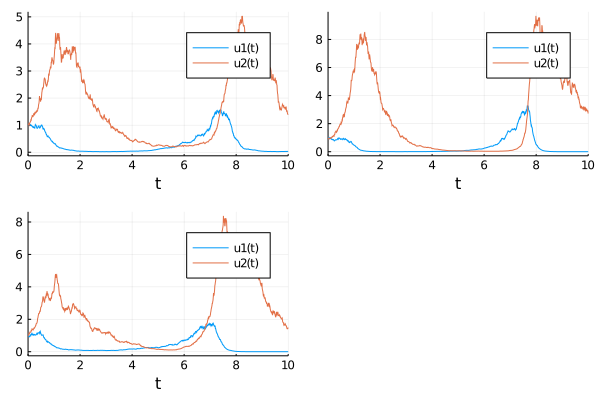

In [12]:
sol = solve(prob,saveat=0.01)
p1 = plot(sol)
sol = solve(prob,saveat=0.01)
p2 = plot(sol)
sol = solve(prob,saveat=0.01)
p3 = plot(sol)
plot(p1,p2,p3)

With the `MonteCarloSummary` it is easy to summarize the results from multiple runs through the `EnsembleProblem` interface, here we run the problem for 1000 `trajectories` and visualize the summary:

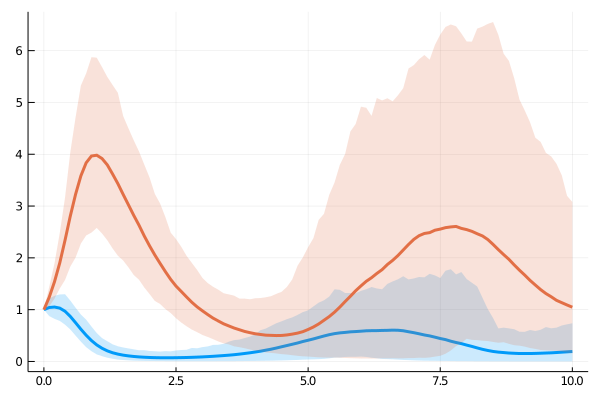

In [13]:
sol = solve(EnsembleProblem(prob),SRIW1(),saveat=0.1,trajectories=500)
summ = MonteCarloSummary(sol)
plot(summ)

Get data from the means to fit:

In [14]:
using DiffEqBase.EnsembleAnalysis
averagedata = Array(timeseries_steps_mean(sol))

2×101 Array{Float64,2}:
 1.0  1.0413   1.05044  1.02993  0.969074  …  0.179612  0.185966  0.192605
 1.0  1.23804  1.53697  1.90187  2.3408       1.13485   1.09019   1.04736

Now fit the means with Turing.

We will utilize multithreading with the [`EnsembleProblem`](https://docs.sciml.ai/stable/tutorials/sde_example/#Ensemble-Simulations-1) interface to speed up the SDE parameter estimation.

In [15]:
Threads.nthreads()

8

In [16]:
Turing.setadbackend(:forwarddiff)

@model function fitlv(data)
    σ ~ InverseGamma(2, 3)
    α ~ truncated(Normal(1.5,0.5),0.5,2.5)
    β ~ truncated(Normal(1.2,0.5),0,2)
    γ ~ truncated(Normal(3.0,0.5),1,4)
    δ ~ truncated(Normal(1.0,0.5),0,2)
    ϕ1 ~ truncated(Normal(1.2,0.5),0.1,1)
    ϕ2 ~ truncated(Normal(1.2,0.5),0.1,1)

    p = [α,β,γ,δ,ϕ1,ϕ2]
    prob = SDEProblem(lotka_volterra,lotka_volterra_noise,u0,(0.0,10.0),p)
    ensemble_predicted = solve(EnsembleProblem(prob),SRIW1(),saveat=0.1,trajectories=500)
    predicted_means = timeseries_steps_mean(ensemble_predicted)

    for i = 1:length(predicted_means)
        data[:,i] ~ MvNormal(predicted_means[i], σ)
    end
end;

model = fitlv(averagedata)
chain = sample(model, NUTS(.65),500)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/vaibhav/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 7:05:53


TaskFailedException: TaskFailedException:
InterruptException:
Stacktrace:
 [1] setup_next_step! at /Users/vaibhav/.julia/packages/DiffEqNoiseProcess/DdXD3/src/noise_interfaces/noise_process_interface.jl:168 [inlined]
 [2] accept_step! at /Users/vaibhav/.julia/packages/DiffEqNoiseProcess/DdXD3/src/noise_interfaces/noise_process_interface.jl:39 [inlined]
 [3] accept_step! at /Users/vaibhav/.julia/packages/StochasticDiffEq/qQyTg/src/integrators/integrator_utils.jl:12 [inlined]
 [4] apply_step! at /Users/vaibhav/.julia/packages/StochasticDiffEq/qQyTg/src/integrators/integrator_utils.jl:283 [inlined]
 [5] loopheader! at /Users/vaibhav/.julia/packages/StochasticDiffEq/qQyTg/src/integrators/integrator_utils.jl:31 [inlined]
 [6] solve!(::StochasticDiffEq.SDEIntegrator{SRIW1,true,Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},Float64,Float64,Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Float64,Float64,ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},NoiseProcess{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},2,Float64,Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Array{Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},1},typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_DIST),typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_BRIDGE),true,ResettableStacks.ResettableStack{Tuple{Float64,Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1}},true},ResettableStacks.ResettableStack{Tuple{Float64,Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1}},true},RSWM{Float64},Nothing,RandomNumbers.Xorshifts.Xoroshiro128Plus},Nothing,Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},RODESolution{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},2,Array{Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},1},Nothing,Nothing,Array{Float64,1},NoiseProcess{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},2,Float64,Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Array{Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},1},typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_DIST),typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_BRIDGE),true,ResettableStacks.ResettableStack{Tuple{Float64,Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1}},true},ResettableStacks.ResettableStack{Tuple{Float64,Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1}},true},RSWM{Float64},Nothing,RandomNumbers.Xorshifts.Xoroshiro128Plus},SDEProblem{Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Tuple{Float64,Float64},true,Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Nothing,SDEFunction{true,typeof(lotka_volterra),typeof(lotka_volterra_noise),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},typeof(lotka_volterra_noise),Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Nothing},SRIW1,StochasticDiffEq.LinearInterpolationData{Array{Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},1},Array{Float64,1}},DiffEqBase.DEStats},StochasticDiffEq.SRIW1Cache{Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1}},SDEFunction{true,typeof(lotka_volterra),typeof(lotka_volterra_noise),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},typeof(lotka_volterra_noise),Nothing,StochasticDiffEq.SDEOptions{Float64,Float64,typeof(DiffEqBase.ODE_DEFAULT_NORM),CallbackSet{Tuple{},Tuple{}},typeof(DiffEqBase.ODE_DEFAULT_ISOUTOFDOMAIN),typeof(DiffEqBase.ODE_DEFAULT_PROG_MESSAGE),typeof(DiffEqBase.ODE_DEFAULT_UNSTABLE_CHECK),DataStructures.BinaryHeap{Float64,DataStructures.LessThan},DataStructures.BinaryHeap{Float64,DataStructures.LessThan},Nothing,Nothing,Int64,ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},Tuple{},Float64,Tuple{}},Nothing,ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},Nothing,Nothing}) at /Users/vaibhav/.julia/packages/StochasticDiffEq/qQyTg/src/solve.jl:509
 [7] #__solve#49 at /Users/vaibhav/.julia/packages/StochasticDiffEq/qQyTg/src/solve.jl:7 [inlined]
 [8] solve_call(::SDEProblem{Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Tuple{Float64,Float64},true,Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Nothing,SDEFunction{true,typeof(lotka_volterra),typeof(lotka_volterra_noise),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},typeof(lotka_volterra_noise),Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Nothing}, ::SRIW1; merge_callbacks::Bool, kwargs::Base.Iterators.Pairs{Symbol,Float64,Tuple{Symbol},NamedTuple{(:saveat,),Tuple{Float64}}}) at /Users/vaibhav/.julia/packages/DiffEqBase/Aj1Ed/src/solve.jl:60
 [9] #solve_up#444 at /Users/vaibhav/.julia/packages/DiffEqBase/Aj1Ed/src/solve.jl:85 [inlined]
 [10] #solve#443 at /Users/vaibhav/.julia/packages/DiffEqBase/Aj1Ed/src/solve.jl:69 [inlined]
 [11] batch_func(::Int64, ::EnsembleProblem{SDEProblem{Array{Float64,1},Tuple{Float64,Float64},true,Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Nothing,SDEFunction{true,typeof(lotka_volterra),typeof(lotka_volterra_noise),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},typeof(lotka_volterra_noise),Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Nothing},typeof(DiffEqBase.DEFAULT_PROB_FUNC),typeof(DiffEqBase.DEFAULT_OUTPUT_FUNC),typeof(DiffEqBase.DEFAULT_REDUCTION),Nothing}, ::SRIW1; kwargs::Base.Iterators.Pairs{Symbol,Float64,Tuple{Symbol},NamedTuple{(:saveat,),Tuple{Float64}}}) at /Users/vaibhav/.julia/packages/DiffEqBase/Aj1Ed/src/ensemble/basic_ensemble_solve.jl:130
 [12] #350 at /Users/vaibhav/.julia/packages/DiffEqBase/Aj1Ed/src/ensemble/basic_ensemble_solve.jl:164 [inlined]
 [13] iterate at ./generator.jl:47 [inlined]
 [14] collect_to!(::Array{RODESolution{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},2,Array{Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},1},Nothing,Nothing,Array{Float64,1},NoiseProcess{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},2,Float64,Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Array{Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},1},typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_DIST),typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_BRIDGE),true,ResettableStacks.ResettableStack{Tuple{Float64,Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1}},true},ResettableStacks.ResettableStack{Tuple{Float64,Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1}},true},RSWM{Float64},Nothing,RandomNumbers.Xorshifts.Xoroshiro128Plus},SDEProblem{Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Tuple{Float64,Float64},true,Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Nothing,SDEFunction{true,typeof(lotka_volterra),typeof(lotka_volterra_noise),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},typeof(lotka_volterra_noise),Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Nothing},SRIW1,StochasticDiffEq.LinearInterpolationData{Array{Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},1},Array{Float64,1}},DiffEqBase.DEStats},1}, ::Base.Generator{UnitRange{Int64},DiffEqBase.var"#350#351"{Base.Iterators.Pairs{Symbol,Float64,Tuple{Symbol},NamedTuple{(:saveat,),Tuple{Float64}}},EnsembleProblem{SDEProblem{Array{Float64,1},Tuple{Float64,Float64},true,Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Nothing,SDEFunction{true,typeof(lotka_volterra),typeof(lotka_volterra_noise),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},typeof(lotka_volterra_noise),Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Nothing},typeof(DiffEqBase.DEFAULT_PROB_FUNC),typeof(DiffEqBase.DEFAULT_OUTPUT_FUNC),typeof(DiffEqBase.DEFAULT_REDUCTION),Nothing},SRIW1}}, ::Int64, ::Int64) at ./array.jl:710
 [15] collect_to_with_first!(::Array{RODESolution{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},2,Array{Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},1},Nothing,Nothing,Array{Float64,1},NoiseProcess{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},2,Float64,Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Array{Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},1},typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_DIST),typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_BRIDGE),true,ResettableStacks.ResettableStack{Tuple{Float64,Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1}},true},ResettableStacks.ResettableStack{Tuple{Float64,Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1}},true},RSWM{Float64},Nothing,RandomNumbers.Xorshifts.Xoroshiro128Plus},SDEProblem{Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Tuple{Float64,Float64},true,Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Nothing,SDEFunction{true,typeof(lotka_volterra),typeof(lotka_volterra_noise),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},typeof(lotka_volterra_noise),Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Nothing},SRIW1,StochasticDiffEq.LinearInterpolationData{Array{Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},1},Array{Float64,1}},DiffEqBase.DEStats},1}, ::RODESolution{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},2,Array{Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},1},Nothing,Nothing,Array{Float64,1},NoiseProcess{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},2,Float64,Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Array{Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},1},typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_DIST),typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_BRIDGE),true,ResettableStacks.ResettableStack{Tuple{Float64,Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1}},true},ResettableStacks.ResettableStack{Tuple{Float64,Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1}},true},RSWM{Float64},Nothing,RandomNumbers.Xorshifts.Xoroshiro128Plus},SDEProblem{Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Tuple{Float64,Float64},true,Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Nothing,SDEFunction{true,typeof(lotka_volterra),typeof(lotka_volterra_noise),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},typeof(lotka_volterra_noise),Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Nothing},SRIW1,StochasticDiffEq.LinearInterpolationData{Array{Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},1},Array{Float64,1}},DiffEqBase.DEStats}, ::Base.Generator{UnitRange{Int64},DiffEqBase.var"#350#351"{Base.Iterators.Pairs{Symbol,Float64,Tuple{Symbol},NamedTuple{(:saveat,),Tuple{Float64}}},EnsembleProblem{SDEProblem{Array{Float64,1},Tuple{Float64,Float64},true,Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Nothing,SDEFunction{true,typeof(lotka_volterra),typeof(lotka_volterra_noise),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},typeof(lotka_volterra_noise),Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Nothing},typeof(DiffEqBase.DEFAULT_PROB_FUNC),typeof(DiffEqBase.DEFAULT_OUTPUT_FUNC),typeof(DiffEqBase.DEFAULT_REDUCTION),Nothing},SRIW1}}, ::Int64) at ./array.jl:689
 [16] _collect(::UnitRange{Int64}, ::Base.Generator{UnitRange{Int64},DiffEqBase.var"#350#351"{Base.Iterators.Pairs{Symbol,Float64,Tuple{Symbol},NamedTuple{(:saveat,),Tuple{Float64}}},EnsembleProblem{SDEProblem{Array{Float64,1},Tuple{Float64,Float64},true,Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Nothing,SDEFunction{true,typeof(lotka_volterra),typeof(lotka_volterra_noise),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},typeof(lotka_volterra_noise),Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Nothing},typeof(DiffEqBase.DEFAULT_PROB_FUNC),typeof(DiffEqBase.DEFAULT_OUTPUT_FUNC),typeof(DiffEqBase.DEFAULT_REDUCTION),Nothing},SRIW1}}, ::Base.EltypeUnknown, ::Base.HasShape{1}) at ./array.jl:683
 [17] collect_similar at ./array.jl:607 [inlined]
 [18] map at ./abstractarray.jl:2072 [inlined]
 [19] solve_batch(::EnsembleProblem{SDEProblem{Array{Float64,1},Tuple{Float64,Float64},true,Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Nothing,SDEFunction{true,typeof(lotka_volterra),typeof(lotka_volterra_noise),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},typeof(lotka_volterra_noise),Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Nothing},typeof(DiffEqBase.DEFAULT_PROB_FUNC),typeof(DiffEqBase.DEFAULT_OUTPUT_FUNC),typeof(DiffEqBase.DEFAULT_REDUCTION),Nothing}, ::SRIW1, ::EnsembleSerial, ::UnitRange{Int64}, ::Int64; kwargs::Base.Iterators.Pairs{Symbol,Float64,Tuple{Symbol},NamedTuple{(:saveat,),Tuple{Float64}}}) at /Users/vaibhav/.julia/packages/DiffEqBase/Aj1Ed/src/ensemble/basic_ensemble_solve.jl:163
 [20] macro expansion at /Users/vaibhav/.julia/packages/DiffEqBase/Aj1Ed/src/ensemble/basic_ensemble_solve.jl:193 [inlined]
 [21] (::DiffEqBase.var"#365#threadsfor_fun#355"{Base.Iterators.Pairs{Symbol,Float64,Tuple{Symbol},NamedTuple{(:saveat,),Tuple{Float64}}},EnsembleProblem{SDEProblem{Array{Float64,1},Tuple{Float64,Float64},true,Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Nothing,SDEFunction{true,typeof(lotka_volterra),typeof(lotka_volterra_noise),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},typeof(lotka_volterra_noise),Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Nothing},typeof(DiffEqBase.DEFAULT_PROB_FUNC),typeof(DiffEqBase.DEFAULT_OUTPUT_FUNC),typeof(DiffEqBase.DEFAULT_REDUCTION),Nothing},SRIW1,UnitRange{Int64},Int64,Int64,UnitRange{Int64}})(::Bool) at ./threadingconstructs.jl:61
 [22] (::DiffEqBase.var"#365#threadsfor_fun#355"{Base.Iterators.Pairs{Symbol,Float64,Tuple{Symbol},NamedTuple{(:saveat,),Tuple{Float64}}},EnsembleProblem{SDEProblem{Array{Float64,1},Tuple{Float64,Float64},true,Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#809",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#810",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},Nothing,SDEFunction{true,typeof(lotka_volterra),typeof(lotka_volterra_noise),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},typeof(lotka_volterra_noise),Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Nothing},typeof(DiffEqBase.DEFAULT_PROB_FUNC),typeof(DiffEqBase.DEFAULT_OUTPUT_FUNC),typeof(DiffEqBase.DEFAULT_REDUCTION),Nothing},SRIW1,UnitRange{Int64},Int64,Int64,UnitRange{Int64}})() at ./threadingconstructs.jl:28